In [30]:
import numpy as np
from copy import deepcopy
from hera_cal.datacontainer import DataContainer

from hera_cal.redcal import get_reds, sim_red_data, parse_pol_mode, get_gains_and_vis_from_sol, noise
from hera_cal.redcal import divide_by_gains, multiply_by_gains, RedundantCalibrator
import linsolve
reload(linsolve)

import matplotlib.pyplot as plt
%matplotlib notebook 

In [31]:
def build_hex_array(hexNum, sep=14.7):
    antpos, i = {}, 0
    for row in range(hexNum-1,-(hexNum),-1):
        for col in range(2*hexNum-abs(row)-1):
            xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*sep;
            yPos = row*sep*3**.5/2;
            antpos[i] = np.array([xPos, yPos, 0])
            i += 1
    return antpos

In [32]:
# antpols = sorted(list(set(''.join(pols))))
# ''.join(antpols[-1])

In [33]:
def parse_sol(sol):
    """Splits a sol dictionary into len(key)==2 entries, taken to be gains or D-terms,
    and len(key)==3 entries, taken to be model visibilities."""

    g = {key: val for key,val in sol.items() if len(key)==2 and len(key[1])==1}
    D = {key: val for key,val in sol.items() if len(key)==2 and len(key[1])==2}    
    v = {key: val for key,val in sol.items() if len(key)==3}
    return g, D, v

def get_ubl_index_to_all_pols(reds):
    '''For each unique baseline group in reds, find which groups have the same baselines with different pols.'''
    pols = sorted(list(set([bl[2] for bls in reds for bl in bls])))
    ubl_index_to_all_pols = {i: {} for i in range(len(reds))}
    for ubl_index1, bls1 in enumerate(reds):
        for pol in pols:
            replaced_set = set([(bl[0],bl[1],pol) for bl in bls1])
            for ubl_index2, bls2 in enumerate(reds):
                if len(replaced_set.intersection(set(bls2))) > 0:
                    ubl_index_to_all_pols[ubl_index1][pol] = ubl_index2
    return ubl_index_to_all_pols

def add_D_terms(data, D_terms=None, D_scatter = .01):
    '''TODO: document (Convention is that D_yx means leakage from y to x)'''
    pols = sorted(list(set([bl[2] for bl in data.keys()])))
    antpols = sorted(list(set(''.join(pols))))
    assert(len(pols) == 4 and len(antpols) == 2)
    D_ants = list(set([(ant_index,Dpol) for bl in data.keys() for ant_index in [bl[0],bl[1]] for 
                       Dpol in [''.join(antpols), ''.join(antpols[::-1])]]))

    if D_terms is None: 
        D_terms = {}
    else: 
        D_terms = deepcopy(D_terms)
    for ant in D_ants:
        D_terms[ant] = D_terms.get(ant, D_scatter*noise((1,))) * np.ones_like(data.values()[0])

    new_data = {}
    for (ant_i,ant_j,pol) in data.keys():
        term_sum = 0.0
        for term_pol in pols:
            term = np.array(data[(ant_i,ant_j,term_pol)])
            if term_pol[0] != pol[0]:
                term *= D_terms[(ant_i, term_pol[0]+pol[0])]
            if term_pol[1] != pol[1]:
                term *= np.conj(D_terms[(ant_j, term_pol[1]+pol[1])])
            term_sum += term
        new_data[(ant_i,ant_j,pol)] = term_sum

    return D_terms, new_data
      

In [34]:
pos = build_hex_array(3)
reds = get_reds(pos, pols=['xx','xy','yx','yy'], pol_mode='4pol')
pols = sorted(list(set([bl[2] for bls in reds for bl in bls])))

gains, true_vis, pure_data = sim_red_data(reds, shape=(1,1), gain_scatter=.1)
D_terms, data = add_D_terms(pure_data)

In [35]:
# print reds[10][3]
# print data[10,13,'xy']
# print pure_data[10,13,'xy']
# print pure_data[10,13,'xy'] + D_terms[10,'yx']*pure_data[10,13,'yy'] + np.conj(D_terms[13,'xy'])*pure_data[10,13,'xx'] + \
#       D_terms[10,'yx']*np.conj(D_terms[13,'xy'])* pure_data[10,13,'yx'] - data[10,13,'xy']

In [36]:
rc = RedundantCalibrator(reds)
sol0 = rc.logcal(pure_data)
meta, sol1 = rc.lincal(pure_data, sol0)
sol = rc.remove_degen(pos, sol1, degen_sol=gains)

for ant in gains.keys():
    assert(np.linalg.norm(sol[ant]-gains[ant]) < 1e-14)
for bl in true_vis.keys():
    assert (np.linalg.norm(true_vis[bl]-sol[bl]) < 1e-14)    

In [37]:


class RedundantCalibrator2:

    def __init__(self, reds):
        """Initialization of a class object for performing redundant calibration with logcal
        and lincal, both utilizing linsolve, and also degeneracy removal.

        Args:
            reds: list of lists of redundant baseline tuples, e.g. (ind1,ind2,pol). The first
                item in each list will be treated as the key for the unique baseline
        """

        self.reds = reds
        self.pol_mode = parse_pol_mode(self.reds)
        self.pols = sorted(list(set([bl[2] for bls in reds for bl in bls])))
        self.antpols = sorted(list(set(''.join(pols))))
        self.ubl_index_to_all_pols = get_ubl_index_to_all_pols(self.reds)


    def build_eqs(self, bls_in_data):
        """Function for generating linsolve equation strings. Takes in a list of baselines that
        occur in the data in the (ant1,ant2,pol) format and returns a dictionary that maps
        linsolve string to (ant1, ant2, pol) for all visibilities."""

        eqs = {}
        #TODO: enforce that the polmode is sensible if necessary (have to think about this)
        for ubl_index, blgrp in enumerate(self.reds):
            for ant_i,ant_j,pol in blgrp:
                if (ant_i,ant_j,pol) in bls_in_data: #TODO: update this check
                    terms = []
                    for ubl_pol, ubl_pol_index in self.ubl_index_to_all_pols[ubl_index].items():
                        term = 'g%d%s * g%d%s_ * u%d%s' % (ant_i, pol[0], ant_j, pol[1], ubl_pol_index, ubl_pol)
                        if pol[0] != ubl_pol[0]:
                            term = 'D%d%s * ' % (ant_i, ubl_pol[0]+pol[0]) + term
                        if pol[1] != ubl_pol[1]:
                            term = 'D%d%s_ * ' % (ant_j, ubl_pol[1]+pol[1]) + term
                        terms.append(term) 
                    eqs[' + '.join(terms)] = (ant_i,ant_j,pol)
        return eqs


    def _solver(self, solver, data, wgts={}, detrend_phs=False, sparse=True, **kwargs):
        """Instantiates a linsolve solver for performing redcal.

        Args:
            solver: linsolve solver (e.g. linsolve.LogProductSolver or linsolve.LinProductSolver)
            data: visibility data in the dictionary format {(ant1,ant2,pol): np.array}
            wgts: dictionary of linear weights in the same format as data. Defaults to equal wgts.
            detrend_phs: takes out average phase, useful for logcal
            sparse: represent the A matrix (visibilities to parameters) sparsely in linsolve
            **kwargs: other keyword arguments passed into the solver for use by linsolve

        Returns:
            solver: instantiated solver with redcal equations and weights
        """

        dc = DataContainer(data)
        eqs = self.build_eqs(dc.keys())
        self.phs_avg = {} # detrend phases within redundant group, used for logcal to avoid phase wraps
        if detrend_phs:
            for blgrp in self.reds:
                self.phs_avg[blgrp[0]] = np.exp(-1j*np.median(np.unwrap([np.log(dc[bl]).imag for bl in blgrp],axis=0), axis=0))
                for bl in blgrp:
                    self.phs_avg[bl] = self.phs_avg[blgrp[0]]
        d_ls,w_ls = {}, {}
        for eq,key in eqs.items():
            d_ls[eq] = dc[key] * self.phs_avg.get(key,1)
        if len(wgts) > 0:
            wc = DataContainer(wgts)
            for eq,key in eqs.items(): w_ls[eq] = wc[key]
        return solver(data=d_ls, wgts=w_ls, sparse=sparse, **kwargs)

    def unpack_sol_key(self, k):
        """Turn linsolve's internal variable string into antenna or baseline tuple (with polarization)."""

        if k.startswith('g'): # 'g' = gain solution
            return (int(k[1:-1]),k[-1])
        elif k.startswith('D'): # 'D' = D-term
            return (int(k[1:-2]),k[-2:])
        else: # 'u' = unique baseline solution
            return self.reds[int(k[1:-2])][0]


    def pack_sol_key(self, k):
        """Turn an antenna or baseline tuple (with polarization) into linsolve's internal variable string."""

        if len(k) == 2 and len(k[1]) == 1: # 'g' = gain solution
            return 'g%d%s' % k
        elif len(k) == 2 and len(k[1]) == 2: # 'D' = D-term
            return 'D%d%s' % k
        else: # 'u' = unique baseline solution
            ubl_num = [cnt for cnt,blgrp in enumerate(self.reds) if blgrp[0] == k][0]
            return 'u%d%s' % (ubl_num, k[-1])


    def compute_ubls(self, data, gain_sols):
        """Given a set of guess gain solutions, return a dictionary of calibrated visbilities
        averged over a redundant group. Not strictly necessary for typical operation."""

        dc = DataContainer(data)
        ubl_sols = {}
        for ubl, blgrp in enumerate(self.reds):
            d_gp = [dc[bl] for bl in blgrp]
            ubl_sols[blgrp[0]] = np.average(d_gp, axis=0) # XXX add option for median here?
        return ubl_sols


    def logcal(self, data, sol0={}, wgts={}, sparse=True):
        """Takes the log to linearize redcal equations and minimizes chi^2.

        Args:
            data: visibility data in the dictionary format {(ant1,ant2,pol): np.array}
            sol0: dictionary that includes all starting (e.g. firstcal) gains in the 
                {(ant,antpol): np.array} format. These are divided out of the data before 
                logcal and then multiplied back into the returned gains in the solution. 
                Default empty dictionary does nothing.
            wgts: dictionary of linear weights in the same format as data. Defaults to equal wgts.
            sparse: represent the A matrix (visibilities to parameters) sparsely in linsolve

        Returns:
            sol: dictionary of gain and visibility solutions in the {(index,antpol): np.array}
                and {(ind1,ind2,pol): np.array} formats respectively
        """

        try: # XXX Can this be done in the unittests instead? -ARP
            import linsolve
        except(ImportError):
            import unittest
            raise unittest.SkipTest('linsolve not detected. linsolve must be installed for this functionality')

        fc_data = divide_by_gains(data, sol0, target_type='vis')
        ls = self._solver(linsolve.LogProductSolver, fc_data, wgts=wgts, detrend_phs=True, sparse=sparse)
        sol = ls.solve()
        sol = {self.unpack_sol_key(k): sol[k] for k in sol.keys()}
        for ubl_key in [k for k in sol.keys() if len(k) == 3]:
            sol[ubl_key] = sol[ubl_key] * self.phs_avg[ubl_key].conj()
        sol_with_fc = multiply_by_gains(sol, sol0, target_type='gain')
        return sol_with_fc


    def lincal(self, data, sol0, wgts={}, sparse=True, conv_crit=1e-10, maxiter=50):
        """Taylor expands to linearize redcal equations and iteratively minimizes chi^2.

        Args:
            data: visibility data in the dictionary format {(ant1,ant2,pol): np.array}
            sol0: dictionary of guess gains and unique model visibilities, keyed by antenna tuples
                like (ant,antpol) or baseline tuples like. Gains should include firstcal gains.
            wgts: dictionary of linear weights in the same format as data. Defaults to equal wgts.
            sparse: represent the A matrix (visibilities to parameters) sparsely in linsolve
            conv_crit: maximum allowed relative change in solutions to be considered converged
            max_iter: maximum number of lincal iterations allowed before it gives up

        Returns:
            meta: dictionary of information about the convergence and chi^2 of the solution
            sol: dictionary of gain and visibility solutions in the {(index,antpol): np.array}
                and {(ind1,ind2,pol): np.array} formats respectively
        """

        try: # XXX Can this be done in the unittests instead? -ARP
            import linsolve
        except(ImportError):
            import unittest
            raise unittest.SkipTest('linsolve not detected. linsolve must be installed for this functionality')

        sol0 = {self.pack_sol_key(k): sol0[k] for k in sol0.keys()}
        ls = self._solver(linsolve.LinProductSolver, data, sol0=sol0, wgts=wgts, sparse=sparse)
        self.ls = ls #TODO: remove this!!!
        meta, sol = ls.solve_iteratively(conv_crit=conv_crit, maxiter=maxiter)
        sol = {self.unpack_sol_key(k): sol[k] for k in sol.keys()}
        return meta, sol


    def remove_degen(self, antpos, sol, degen_sol=None):
        """ Removes degeneracies from solutions (or replaces them with those in degen_sol).

        Args:
            antpos: dictionary of antenna positions in the form {ant_index: np.array([x,y,z])}.
            sol: dictionary that contains both visibility and gain solutions in the
                {(ind1,ind2,pol): np.array} and {(index,antpol): np.array} formats respectively
            degen_sol: Optional dictionary in the same format as sol. Gain amplitudes and phases
                in degen_sol replace the values of sol in the degenerate subspace of redcal. If
                left as None, average gain amplitudes will be 1 and average phase terms will be 0. 
                Visibilties in degen_sol are ignored. Putting in firstcal solutions here can 
                help avoid phasewrapping issues.
        Returns:
            newSol: sol with degeneracy removal/replacement performed
        """

        g, v = get_gains_and_vis_from_sol(sol)
        if degen_sol is None:
            degen_sol = {key: np.ones_like(val) for key,val in g.items()}
        ants = g.keys()

        gainPols = np.array([ant[1] for ant in ants])
        # gainPols is list of antpols, one per antenna
        antpols = list(set(gainPols))
        positions = np.array([antpos[ant[0]] for ant in ants])
        bl_pairs = v.keys()
        visPols = np.array([[bl[2][0], bl[2][1]] for bl in bl_pairs])
        # visPols is list of pol, one per baseline
        bl_vecs = np.array([antpos[bl_pair[0]] - antpos[bl_pair[1]] for bl_pair in bl_pairs])
        if self.pol_mode not in ['1pol', '2pol', '4pol', '4pol_minV']:
            raise ValueError, 'Remove_degen cannot operate on pol_mode determined from reds'

        #if mode is 2pol, run as two 1pol remove degens
        if self.pol_mode is '2pol':
            self.pol_mode = '1pol'
            newSol = self.remove_degen(antpos, {key: val for key,val in sol.items()
                     if antpols[0] in key[-1]}, degen_sol=degen_sol)
            newSol.update(self.remove_degen(antpos, {key: val for key,val in sol.items()
                     if antpols[1] in key[-1]}, degen_sol=degen_sol))
            self.pol_mode = '2pol'
            return newSol

        #Extract gain and model visibiltiy solutions
        gainSols = np.array([sol[ant] for ant in ants])
        visSols = np.array([sol[bl_pair] for bl_pair in bl_pairs])
        degenGains = np.array([degen_sol[ant] for ant in ants])

        #Amplitude renormalization: fixes the mean abs product of gains (as they appear in visibilities)
        for antpol in antpols:
            meanSqAmplitude = np.mean([np.abs(g[(ant1,pol[0])] * g[(ant2,pol[1])])
                for (ant1,ant2,pol) in bl_pairs if pol == 2*antpol], axis=0)
            degenMeanSqAmplitude = np.mean([np.abs(degen_sol[(ant1,pol[0])] * degen_sol[(ant2,pol[1])])
                for (ant1,ant2,pol) in bl_pairs if pol == 2*antpol], axis=0)
            gainSols[gainPols == antpol] *= (degenMeanSqAmplitude / meanSqAmplitude)**.5
            visSols[visPols[:,0] == antpol] *= (meanSqAmplitude / degenMeanSqAmplitude)**.5
            visSols[visPols[:,1] == antpol] *= (meanSqAmplitude / degenMeanSqAmplitude)**.5

        # Fix phase terms
        if self.pol_mode is '1pol' or self.pol_mode is '4pol_minV':
            # In 1pol and 4pol_minV, the phase degeneracies are 1 overall phase and 2 tip-tilt terms
            # Rgains maps gain phases to degenerate parameters (either average phases or phase slopes)
            Rgains = np.hstack((positions, np.ones((positions.shape[0],1))))
            # Rvis maps visibility phases to the same set of degenerate parameters, keeping chi^2 constant
            Rvis = np.hstack((-bl_vecs, np.zeros((len(bl_vecs),1))))
        else: # pole_mode is '4pol'
            # two columns give sums for two different polarizations
            phasePols = np.vstack((gainPols==antpols[0], gainPols==antpols[1])).T
            Rgains = np.hstack((positions, phasePols))
            # These terms detect cross terms only, which pick up overall phase terms in 4pol (see HERA memo #30)
            is_ab = np.array((visPols[:,0] == antpols[0]) * (visPols[:,1] == antpols[1]),dtype=float)
            is_ba = np.array((visPols[:,0] == antpols[1]) * (visPols[:,1] == antpols[0]),dtype=float)
            visPhaseSigns = np.vstack((is_ab-is_ba, is_ba-is_ab)).T
            Rvis = np.hstack((-bl_vecs, -visPhaseSigns))
        # Mgains is like (AtA)^-1 At in linear estimator formalism. It's a normalized estimator of degeneracies
        Mgains = np.linalg.pinv(Rgains.T.dot(Rgains)).dot(Rgains.T)
        # degenToRemove is the amount we need to move in the degenerate subspace
        degenToRemove = np.einsum('ij,jkl', Mgains, np.angle(gainSols*np.conj(degenGains)))
        # Now correct gains and visibilities while preserving chi^2
        gainSols *= np.exp(-1.0j * np.einsum('ij,jkl',Rgains,degenToRemove))
        visSols *= np.exp(-1.0j * np.einsum('ij,jkl',Rvis,degenToRemove))

        #Create new solutions dictionary
        newSol = {ant: gainSol for ant,gainSol in zip(ants,gainSols)}
        newSol.update({bl_pair: visSol for bl_pair,visSol in zip(bl_pairs,visSols)})

        return newSol

rc = RedundantCalibrator(reds)
sol0 = rc.logcal(data)
meta, sol1 = rc.lincal(data, sol0)

rc2 = RedundantCalibrator2(reds)
sol1.update({key: np.zeros_like(val) for key,val in D_terms.items()})
meta, sol2 = rc2.lincal(data, sol1)


#sol = rc2.remove_degen(pos, sol1, degen_sol=gains)
# for ant in gains.keys():
#     assert(np.linalg.norm(sol[ant]-gains[ant]) < 1e-14)
# for bl in true_vis.keys():
#     assert (np.linalg.norm(true_vis[bl]-sol[bl]) < 1e-14)    

In [38]:
g, D, v = parse_sol(sol2)
A = rc2.ls.ls.get_A()[:,:,0]
AtA = A.T.dot(A)

In [39]:
len(AtA) - np.linalg.matrix_rank(AtA) 

10

In [40]:
meta

{'chisq': array([[  1.70794923e-29]]),
 'conv_crit': array([[  1.05802883e-16]]),
 'iter': 4}

<IPython.core.display.Javascript object>


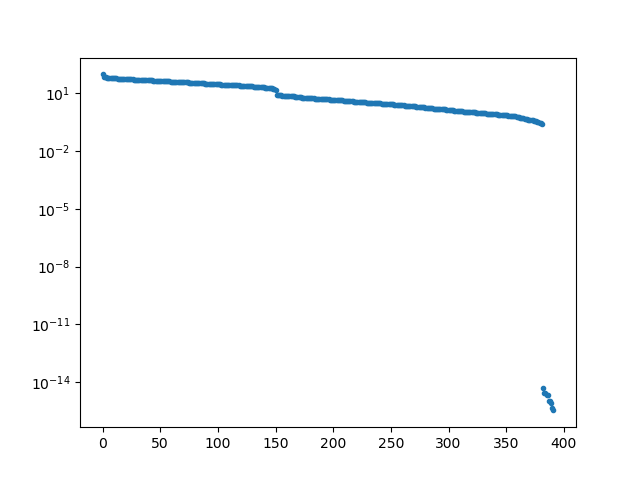

In [41]:
plt.figure()
plt.semilogy(sorted(np.abs(np.linalg.eigvals(AtA)))[::-1],'.')

In [42]:
reload(linsolve)
ls = linsolve.LinearSolver({'a+b':np.array([5.0,2.0]), 'a-b':np.array([3.0,2.0])}, sparse=True)
ls.solve(verbose=True)

Solving 0/2
Solving 1/2


{'a': array([ 4.,  2.]), 'b': array([ 1.,  0.])}